***IMPORTS***

In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from types import SimpleNamespace

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

***UTILS***

In [4]:
def eval(model, device, dataset_loader, debug=False, classification_report_flag=False, is_cnn=True, logger=print):

    """
    Evaluates the model on the given dataset loader.

    Parameters:
    - model: the PyTorch model to evaluate.
    - device: the device to which tensors should be moved before computation.
    - dataset_loader: DataLoader for evaluation.
    - debug: whether to print debug info like loss and accuracy.
    - classification_report_flag: whether to print a classification report.
    - is_cnn: a flag indicating if the model is a CNN. If it's not, the input data will be reshaped.
    - logger: logging function for printing messages.

    Returns:
    - Accuracy of the model on the provided dataset loader.

    Usage:
    - accuracy = eval(model, device, dataset_loader, debug=False, is_cnn=False, classification_report_flag=False)
    """

    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataset_loader:
            if is_cnn:
              data = data.view(data.size(0), 1, 28, 28)
            else:
              data = data.reshape([data.shape[0], -1])
            data, target = data.to(device), target.to(device)
            output = model(data).to(device)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data

    if debug:
        logger('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        unique_labels = np.unique(all_labels).tolist()
        logger(classification_report(all_labels, all_preds, labels=unique_labels, target_names=[f'Class {i}' for i in unique_labels]))

    return acc

In [5]:
class Trainer:

    """
    A class for training and evaluating a model with early stopping and best model saving functionalities.

    Attributes:
    - model: PyTorch model to be trained and evaluated.
    - dataloader: Contains data loaders (train, validation, test) for training and evaluation.
    - params: Dictionary containing various hyperparameters and settings.
    - device: the device to which tensors should be moved before computation.
    - optimizer: The optimizer for training.
    - best_model_state: State dictionary of the best model.
    - max_val_acc: The highest validation accuracy encountered during training.
    - no_improve_epochs: Number of epochs without improvement in validation accuracy.
    - is_cnn: Flag indicating if the model is a CNN.
    - is_debug: Flag indicating if debug information should be printed.
    - classification_report_flag: Flag indicating if a classification report should be generated.

    Methods:
    - train_epoch(): Runs a single epoch of training.
    - evaluate(loader): Evaluates the model on a given data loader.
    - save_best_model(): Saves the current state of the model as the best model.
    - save_checkpoint(epoch, train_acc, val_acc): Saves the current state of the model and other information as a checkpoint.
    - early_stopping_check(val_acc): Checks the stopping criterion and performs actions based on it.
    - train(): Runs the training process for a number of epochs, with early stopping functionality.

    Usage:
    params = {
      'device': 'cuda',
      'lr': 0.001,
      'num_train': 10,
      'early_stop_patience': 3,
      'save_best': True,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': True
    }

    trainer = Trainer(model, dataloader, params)
    train_acc, test_acc, effective_epochs, checkpoints = trainer.train()
    """


    def __init__(self, model, dataloader, params):
        # Initializes the Trainer class with model, dataloader, and parameters
        self.model = model
        self.dataloader = dataloader
        self.params = params

        self.device = torch.device(params['device'])
        self.optimizer = optim.Adam(model.parameters(), lr=params['lr'])

        self.best_model_state = None
        self.max_val_acc = 0.
        self.no_improve_epochs = 0

        self.is_cnn = params.get('is_cnn', False)
        self.is_debug = params.get('is_debug', False)
        self.classification_report_flag = params.get('classification_report_flag', False)
        self.logger = params.get('logger', print)

    def train_epoch(self):
      self.model.train()
      for batch_idx, (data, target) in enumerate(self.dataloader.train_loader):

          # Print the size of the current batch
          if self.is_cnn:
            data = data.view(data.size(0), 1, 28, 28)
          else:
            data = data.reshape([data.shape[0], -1])

          data, target = data.to(self.device), target.to(self.device)
          self.optimizer.zero_grad()
          output = self.model(data).to(device)
          loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()

          if self.is_debug and batch_idx % 20 == 0:
              self.logger(f"Batch: {batch_idx}, Loss: {loss.item()}")

    def evaluate(self, loader):
        return eval(self.model, self.device, loader, self.is_debug, self.classification_report_flag, self.is_cnn)

    def save_best_model(self):
        torch.save(self.model.state_dict(), 'best_model.pth')

    def save_checkpoint(self, epoch, train_acc, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
        return checkpoint

    def early_stopping_check(self, val_acc):
        if val_acc > self.max_val_acc:
            self.max_val_acc = val_acc
            self.no_improve_epochs = 0
            self.best_model_state = self.model.state_dict()  # Store the best model state
            if self.params.get('save_best', False):  # Only save if save_best is True
                self.save_best_model()  # Save the current model as the best model
        else:
            self.no_improve_epochs += 1
            if self.no_improve_epochs >= self.params['early_stop_patience']:
                print("Early stopping invoked.")
                self.model.load_state_dict(self.best_model_state)
                return True
        return False

    def train(self):
        effective_epochs = 0
        checkpoints = []

        for epoch in range(self.params['num_train']):
            effective_epochs += 1
            self.train_epoch()

            train_acc = self.evaluate(self.dataloader.train_loader)
            val_acc = self.evaluate(self.dataloader.val_loader)
            self.logger(f'Epoch: {epoch} \tTraining Accuracy: {train_acc*100:.2f}%')
            self.logger(f'Validation Accuracy: {val_acc*100:.2f}%')

            if self.params.get('early_stop_patience', None):
                if self.early_stopping_check(val_acc):
                    self.model.load_state_dict(self.best_model_state)
                    break

            if self.params.get('save_checkpoints', False):
                checkpoint = self.save_checkpoint(epoch, train_acc, val_acc)
                checkpoints.append(checkpoint)

        # Final evaluations
        train_acc = self.evaluate(self.dataloader.train_loader)
        test_acc = self.evaluate(self.dataloader.test_loader)

        return train_acc, test_acc, effective_epochs, checkpoints

In [6]:
def reduce_dataset(dataloader, percentage, balanced=True, seed=42):

    """
    Reduces the dataset to the given percentage. Can ensure class balance if needed.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - balanced: If True, ensures class balance. If False, reduces randomly.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset

    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    if not balanced:
        # Determine the number of samples to keep
        num_samples = int(len(dataset) * percentage)

        # Randomly select indices without replacement
        indices = torch.randperm(len(dataset))[:num_samples].tolist()

    else:
        # Get unique classes and their counts
        classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)

        # Determine the number of samples per class to keep
        num_samples_per_class = int(len(dataset) * percentage / len(classes))
        indices = []

        for class_label in classes:
            class_indices = [i for i, label in enumerate(y) if label == class_label]

            # Randomly select indices without replacement for each class
            class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
            indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset.
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

In [7]:
class TransferLearningMNIST(object):
    """
    This class loads the MNIST dataset and splits it for transfer learning.

    Specifically, it partitions the MNIST dataset into two subsets:
    1) Digits 0-4 (for pre-training)
    2) Digits 5-9 (for fine-tuning)
    Additionally, it creates validation splits and data loaders for both subsets.
    """
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1):
        """
        Initializes the TransferLearningMNIST object.

        Parameters:
        - batch_size: Size of each batch in the data loader.
        - input_dim: Input dimensions for the dataset. Default is 28*28 (MNIST image size).
        - val_split: Fraction of data to be used as validation set.
        """
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        # Helper function to filter dataset based on specific classes.
        def filter_dataset(dataset, classes):
            """
            Filters the dataset to only include data of the given classes.

            Parameters:
            - dataset: The dataset to be filtered.
            - classes: List of classes to be retained.

            Returns:
            - Subset of the dataset with only the desired classes.
            """
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return torch.utils.data.Subset(dataset, indices)

        # Load and preprocess the MNIST training data.
        mnist_train_data = datasets.MNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                # Normalize the data by scaling to [-0.5, 0.5]
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        # Split the training data for pretraining and fine-tuning phases.
        pretrain_train_data = filter_dataset(mnist_train_data, list(range(5)))
        finetune_train_data = filter_dataset(mnist_train_data, list(range(5, 10)))

        # Split the data into training and validation sets for both pretraining and fine-tuning phases.
        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(val_split * pretrain_len)
        finetune_val_len = int(val_split * finetune_len)
        SEED = 42  # Seed for random splitting
        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len], generator=torch.Generator().manual_seed(SEED))
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len], generator=torch.Generator().manual_seed(SEED))

        # Create data loaders for both training and validation sets.
        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True)
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False)
        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True)
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False)

        # Load and preprocess the MNIST test data, then create data loaders for testing.
        mnist_test_data = datasets.MNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        # Split the test data for pretraining and fine-tuning phases.
        pretrain_test_data = filter_dataset(mnist_test_data, list(range(5)))
        finetune_test_data = filter_dataset(mnist_test_data, list(range(5, 10)))

        # Create data loaders for the test sets.
        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False)
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False)
        # Complete test loader contains all test examples.
        self.complete_test_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=batch_size, shuffle=False)

In [8]:
class TransferLearningMNISTWrapper:
    """
    This wrapper class provides a convenient way to switch between pretraining and fine-tuning phases.

    It allows for changing the phase and accordingly updating the data loaders (train, val, test)
    to either pretraining or fine-tuning sets.
    """
    def __init__(self, transferLearningMNISTObj, phase):
        """
        Initializes the TransferLearningMNISTWrapper object.

        Parameters:
        - transferLearningMNISTObj: An instance of the TransferLearningMNIST class.
        - phase: String indicating the current phase ("pretrain" or "finetune").
        """
        self.transferLearningMNISTObj = transferLearningMNISTObj
        self.phase = phase
        self.input_dim = self.transferLearningMNISTObj.input_dim
        self.output_dim = self.transferLearningMNISTObj.output_dim
        self.update_phase(phase)

    def update_phase(self, phase):
        """
        Updates the phase and the corresponding data loaders.

        Parameters:
        - phase: String indicating the desired phase ("pretrain" or "finetune").

        Throws:
        - ValueError: If the phase is neither "pretrain" nor "finetune".
        """
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.transferLearningMNISTObj.pretrain_train_loader
            self.val_loader = self.transferLearningMNISTObj.pretrain_val_loader
            self.test_loader = self.transferLearningMNISTObj.pretrain_test_loader
        elif phase == 'finetune':
            self.train_loader = self.transferLearningMNISTObj.finetune_train_loader
            self.val_loader = self.transferLearningMNISTObj.finetune_val_loader
            self.test_loader = self.transferLearningMNISTObj.finetune_test_loader
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

    def get_current_phase(self):
      return self.phase

In [41]:
class CustomCNN(nn.Module):
    def __init__(self, input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling=True):
        super(CustomCNN, self).__init__()

        # Initial number of input channels, assuming grayscale images
        in_channels = 1

        # Dynamically add convolutional and activation layers based on the specified depth
        for i in range(depth):
            # Create a convolutional layer and add it to the model
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, num_channels, kernel_size=kernel_size, padding=1))

            # Create an activation layer (e.g., ReLU) and add it to the model
            setattr(self, f"act{i}", activation_function())

            # Update the input dimensions after convolution
            input_dim = (input_dim - kernel_size + 2 * 1) + 1

            # Optionally add pooling layers to reduce spatial dimensions
            if use_pooling and i % 2 == 0:
                setattr(self, f"pool{i}", nn.MaxPool2d(2))
                input_dim = input_dim // 2

            # Update the input channels for the next convolutional layer
            in_channels = num_channels

        # Compute the size of the flattened features for the fully connected layer
        flattened_size = in_channels * input_dim * input_dim

        # Add two fully connected layers for classification
        self.fc_1 = nn.Linear(flattened_size, hidden_dim_lin)
        self.fc_2 = nn.Linear(hidden_dim_lin, output_dim)

        # Add log softmax layer for multi-class classification output
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
      # Iterate over each module in the CustomCNN class
      for layer_name, layer in self.named_children():
          # Process the input tensor through convolutional and activation layers
          if "conv" in layer_name or "act" in layer_name:
              x = layer(x)
          # Process the input tensor through pooling layers if they exist
          elif "pool" in layer_name:
              x = layer(x)
          # If reached fully connected layers, break the loop
          elif isinstance(layer, nn.Linear):
              break

      # Flatten the tensor to fit the input shape of the fully connected layers
      x = x.view(x.size(0), -1)

      # Pass the tensor through the fully connected layers
      x = self.fc_1(x)
      x = self.fc_2(x)

      # Return log softmax activated output
      return self.logsoftmax(x)

In [42]:
def generate_cnn(input_dim, output_dim, depth, num_channels, hidden_dim_lin, kernel_size, activation_function=nn.ReLU, use_pooling=True):
    model = CustomCNN(input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling)
    return model

***PRE-TRAINING***

In [11]:
batch_size = 128

dataloader = TransferLearningMNIST(batch_size)
dataloader_wrapped = TransferLearningMNISTWrapper(dataloader, phase = 'pretrain')

100%|██████████| 9912422/9912422 [00:00<00:00, 64851497.28it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 53647340.05it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28982015.43it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8268458.67it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



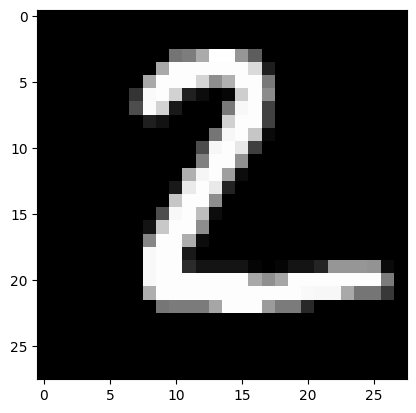

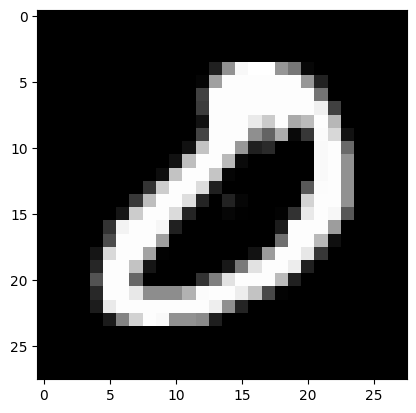

In [12]:
a = dataloader_wrapped.test_loader
b = dataloader_wrapped.train_loader

#check if the content of the two loaders are the same, and print the respective mnist images, use zip
for i, (data_a, data_b) in enumerate(zip(a, b)):
        plt.imshow(data_a[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        plt.imshow(data_b[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        break

In [43]:
# params = dict(device=device,
#                 width=2, lr=0.01, num_train=10,
#                 sb=0.05, depth= depth, sw=1.7346938775510203, early_stop_patience = 4, activation_function='ReLU')

params = {
      'depth': 2,
      'width': 1,
      'hidden_dim_lin': 256,
      'activation_function': nn.ReLU,
      'kernel_size': 5,
      'device': device,
      'lr': 0.001,
      'num_train': 10,
      'early_stop_patience': 3,
      'save_best': True,
      'save_checkpoints': True,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': False
    }

# Create DNN model
model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=True)
model.to(device)

CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=121, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [44]:
# Train and evaluate
trainer = Trainer(model, dataloader_wrapped, params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

Batch: 0, Loss: 2.310044050216675
Batch: 20, Loss: 1.6072031259536743
Batch: 40, Loss: 1.0776562690734863
Batch: 60, Loss: 0.7160003781318665
Batch: 80, Loss: 0.5204676389694214
Batch: 100, Loss: 0.4926891326904297
Batch: 120, Loss: 0.3164038062095642
Batch: 140, Loss: 0.31365713477134705
Batch: 160, Loss: 0.27507489919662476
Batch: 180, Loss: 0.3212420642375946
Batch: 200, Loss: 0.3594924211502075

Average loss: 0.3009, Accuracy: 23701.0/26464 (90%)


Average loss: 0.3197, Accuracy: 2608.0/2940 (89%)

Epoch: 0 	Training Accuracy: 89.56%
Validation Accuracy: 88.71%
Batch: 0, Loss: 0.29012465476989746
Batch: 20, Loss: 0.3531568944454193
Batch: 40, Loss: 0.3207933306694031
Batch: 60, Loss: 0.2607112526893616
Batch: 80, Loss: 0.3100772500038147
Batch: 100, Loss: 0.3164849579334259
Batch: 120, Loss: 0.13768106698989868
Batch: 140, Loss: 0.25654473900794983
Batch: 160, Loss: 0.31577134132385254
Batch: 180, Loss: 0.2675042748451233
Batch: 200, Loss: 0.2763218283653259

Average loss: 0.2268, 

In [45]:
accuracy = eval(model, device, dataloader_wrapped.test_loader, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])


Average loss: 0.1583, Accuracy: 4618.0/4861 (95%)



conv0.weight: 3.3554
conv1.weight: 3.7096
fc_1.weight: 89.2638
fc_2.weight: 8.8841


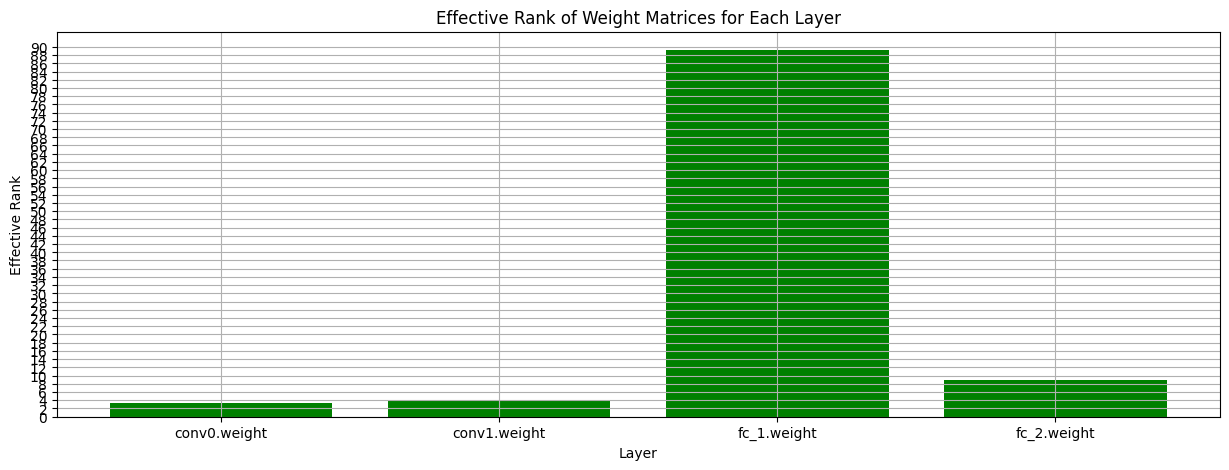

In [46]:
def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []

    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)

    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_effective_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


----

# Finetuning experiments

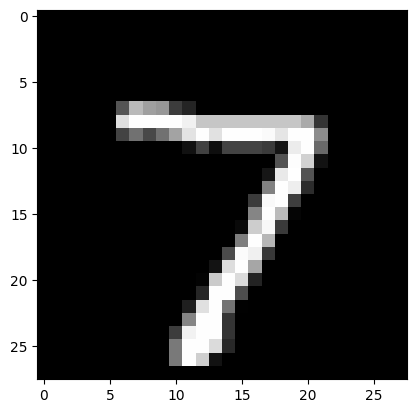

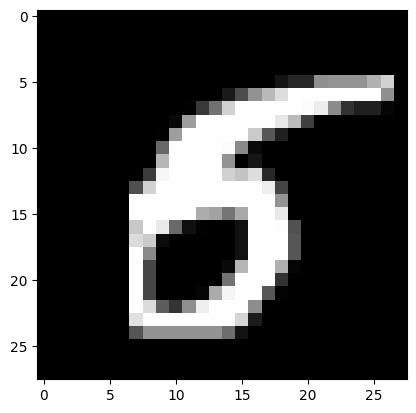

-------------


In [47]:
dataloader_wrapped.update_phase('finetune')

a = dataloader_wrapped.test_loader
b = dataloader_wrapped.train_loader

#check if the content of the two loaders are the same, and print the respective mnist images, use zip
for i, (data_a, data_b) in enumerate(zip(a, b)):
        plt.imshow(data_a[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        plt.imshow(data_b[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        print('-------------')
        break


## Baseline model: end2end with the same architecture as the preatining model

In [48]:
# 2. Create a new model and copy weights from the original model, then adjust the final layer
print("Current dataloader phase: ", dataloader_wrapped.get_current_phase())

model_finetuning_baseline = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=True)
model_finetuning_baseline.to(device)

# dataloader_wrapped.update_phase('finetune')
# Train and evaluate the new model on the new data
# train_acc_new, test_acc_new, model_finetuning_baseline, _,_ = compute_training_acc_epochs_cnn(model_finetuning_baseline, dataloader_wrapped, params, debug=True)

trainer = Trainer(model, dataloader_wrapped, params)
train_acc_new, test_acc_new, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
print(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")

Current dataloader phase:  finetune
Batch: 0, Loss: 0.1385241001844406
Batch: 20, Loss: 0.1270671933889389
Batch: 40, Loss: 0.15528585016727448
Batch: 60, Loss: 0.2396826446056366
Batch: 80, Loss: 0.1387142837047577
Batch: 100, Loss: 0.12606613337993622
Batch: 120, Loss: 0.1120540127158165
Batch: 140, Loss: 0.2399643510580063
Batch: 160, Loss: 0.12695367634296417
Batch: 180, Loss: 0.15205150842666626
Batch: 200, Loss: 0.19781160354614258

Average loss: 0.1560, Accuracy: 25028.0/26464 (95%)


Average loss: 0.1604, Accuracy: 2788.0/2940 (95%)

Epoch: 0 	Training Accuracy: 94.57%
Validation Accuracy: 94.83%
Batch: 0, Loss: 0.17026108503341675
Batch: 20, Loss: 0.17030327022075653
Batch: 40, Loss: 0.1281176060438156
Batch: 60, Loss: 0.1319156289100647
Batch: 80, Loss: 0.23746395111083984
Batch: 100, Loss: 0.11822177469730377
Batch: 120, Loss: 0.09020204097032547
Batch: 140, Loss: 0.12516158819198608
Batch: 160, Loss: 0.09553318470716476
Batch: 180, Loss: 0.15938019752502441
Batch: 200, Loss

conv0.weight: 4.1815
conv1.weight: 4.3441
fc_1.weight: 112.7709
fc_2.weight: 9.9289


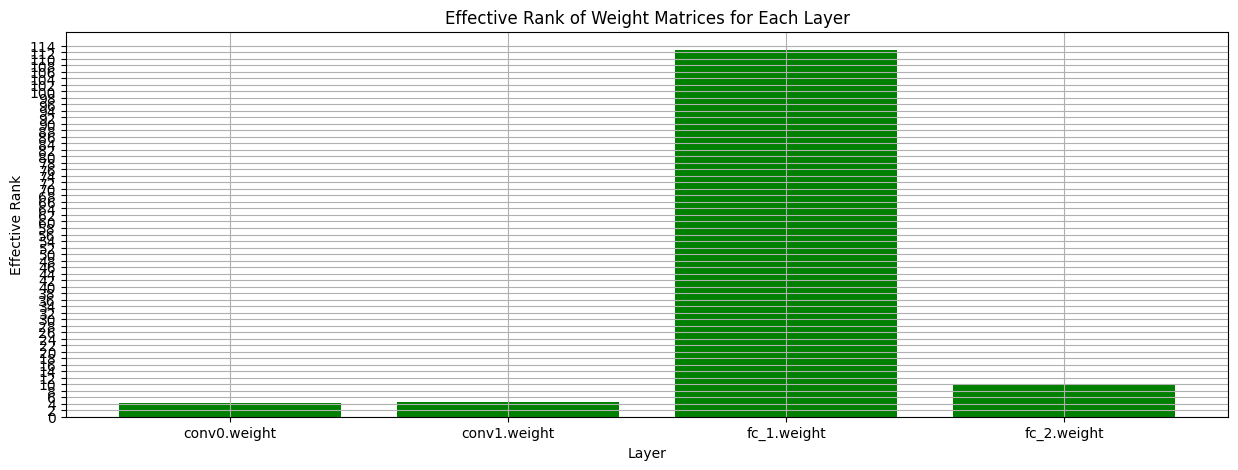

In [49]:
plot_layer_effective_ranks(model_finetuning_baseline)

***WITH BALANCED CLASSES***

Percentage: 0.01
Repeat: 0, with seed 93 =========================
Batch: 0, Loss: 2.28822660446167

Average loss: 1.8680, Accuracy: 57.0/260 (22%)


Average loss: 1.8698, Accuracy: 650.0/2940 (22%)

Epoch: 0 	Training Accuracy: 21.92%
Validation Accuracy: 22.11%
Batch: 0, Loss: 1.8674595355987549

Average loss: 1.5879, Accuracy: 62.0/260 (24%)


Average loss: 1.6311, Accuracy: 689.0/2940 (23%)

Epoch: 1 	Training Accuracy: 23.85%
Validation Accuracy: 23.44%
Batch: 0, Loss: 1.5995644330978394

Average loss: 1.3786, Accuracy: 101.0/260 (39%)


Average loss: 1.4193, Accuracy: 1131.0/2940 (38%)

Epoch: 2 	Training Accuracy: 38.85%
Validation Accuracy: 38.47%
Batch: 0, Loss: 1.3908236026763916

Average loss: 0.9276, Accuracy: 173.0/260 (67%)


Average loss: 1.0048, Accuracy: 1870.0/2940 (64%)

Epoch: 3 	Training Accuracy: 66.54%
Validation Accuracy: 63.61%
Batch: 0, Loss: 0.9311725497245789

Average loss: 0.7864, Accuracy: 166.0/260 (64%)


Average loss: 0.9886, Accuracy: 1694.0/2940 (58%)

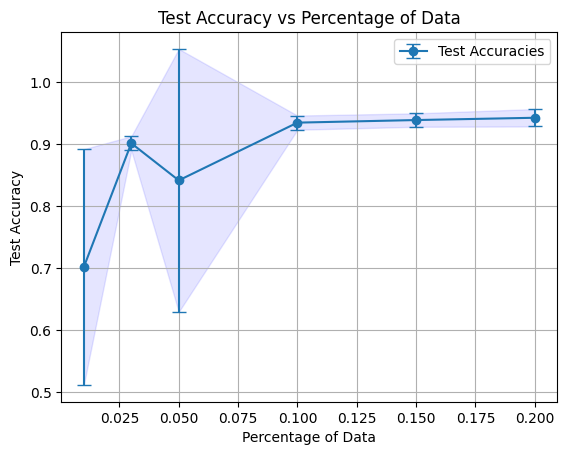

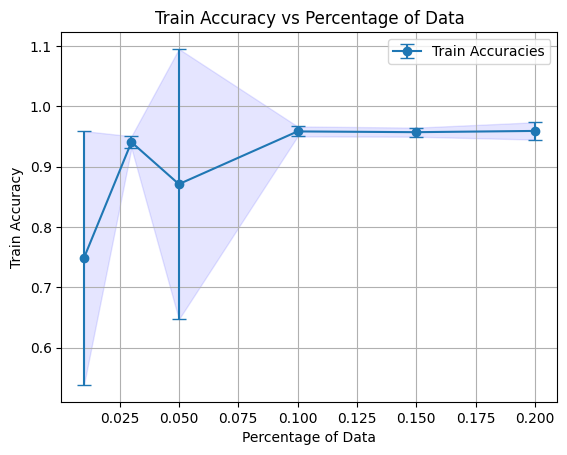

In [50]:
dataloader_wrapped.update_phase('finetune')

#percentages_set_1 = np.linspace(0.1, 1.0, 10)  # from 10% to 100%
percentages_set_1 = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
repeats = 3

params['lr'] = 0.01
params['num_train'] = 10
params['early_stop_patience'] = 4

# Store results for each percentage
results_test_1 = {}
results_train_1 = {}
best_models_1 = {}
data_loaders_1 = {}
epochs_taken_1 = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in percentages_set_1:
    print(f"Percentage: {perc}")
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []  # Store epochs for this percentage

    for _, temp_seed in enumerate(seed_set):
        #temp_seed as a random seed
        temp_seed  = random.randint(0, 100)
        print(f"Repeat: {_}, with seed {temp_seed} =========================")
        model_new =  generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=True)
        model_new.to(device)

        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset(dataloader_wrapped.train_loader, perc, balanced = True, seed=temp_seed)

        if _ == 0:
            data_loaders_1[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataloader_wrapped.test_loader
        val_loader_transfer_reduced = dataloader_wrapped.val_loader

        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)

        # Train and evaluate the new model on the new data
        trainer = Trainer(model_new, dataset_namespace_new, params)
        train_acc_new, test_acc_new, effective_epochs, checkpoints = trainer.train()

        print(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
        print(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")

        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(effective_epochs)

        print('eval on reduced train set')
        accuracy = eval(model_new, device, train_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])
        print('eval on full test set')
        accuracy = eval(model_new, device, test_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])

        # Uncomment this block if you need the best model per percentage logic
        # if train_acc_new > best_accuracy:
        #     best_accuracy = train_acc_new
        #     best_models[perc] = model_new.state_dict()  # Save only the model's parameters (state_dict)

    results_test_1[perc] = test_accuracies
    results_train_1[perc] = train_accuracies
    epochs_taken_1[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages_set_1:
    for seed, epoch_num in zip(seed_set, epochs_taken_1[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")


# Save the best models
# for perc in best_models:
#     torch.save(best_models[perc], f"best_model_{int(perc*100)}_percent.pth")

# Plot the results
means = [np.mean(results_test_1[perc]) for perc in percentages_set_1]
stds = [np.std(results_test_1[perc]) for perc in percentages_set_1]
plt.errorbar(percentages_set_1, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages_set_1, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train_1[perc]) for perc in percentages_set_1]
stds = [np.std(results_train_1[perc]) for perc in percentages_set_1]
plt.errorbar(percentages_set_1, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages_set_1, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


Percentage: 0.1
Repeat: 0, with seed 6 =========================
Batch: 0, Loss: 2.2673864364624023
Batch: 20, Loss: 0.46532049775123596

Average loss: 0.4128, Accuracy: 2229.0/2645 (84%)


Average loss: 0.4524, Accuracy: 2455.0/2940 (84%)

Epoch: 0 	Training Accuracy: 84.27%
Validation Accuracy: 83.50%
Batch: 0, Loss: 0.3469182550907135
Batch: 20, Loss: 0.23573675751686096

Average loss: 0.2497, Accuracy: 2420.0/2645 (91%)


Average loss: 0.3108, Accuracy: 2625.0/2940 (89%)

Epoch: 1 	Training Accuracy: 91.49%
Validation Accuracy: 89.29%
Batch: 0, Loss: 0.2771879732608795
Batch: 20, Loss: 0.17595413327217102

Average loss: 0.1791, Accuracy: 2500.0/2645 (95%)


Average loss: 0.2413, Accuracy: 2709.0/2940 (92%)

Epoch: 2 	Training Accuracy: 94.52%
Validation Accuracy: 92.14%
Batch: 0, Loss: 0.09352150559425354
Batch: 20, Loss: 0.12707270681858063

Average loss: 0.1597, Accuracy: 2507.0/2645 (95%)


Average loss: 0.2394, Accuracy: 2725.0/2940 (93%)

Epoch: 3 	Training Accuracy: 94.78%
Va

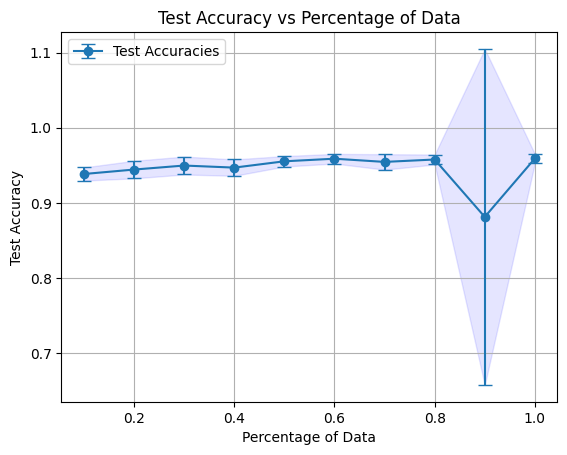

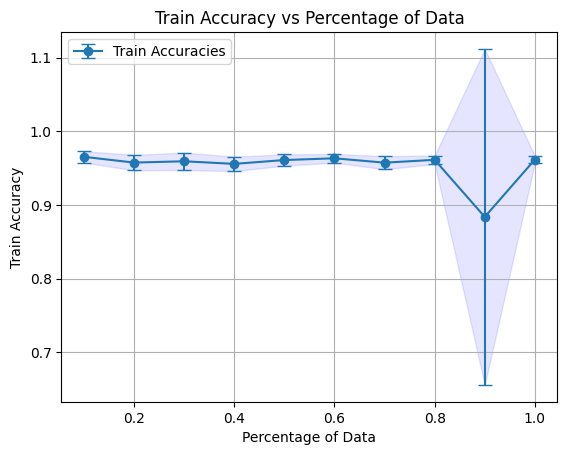

In [51]:
params['lr'] = 0.01
params['num_train'] = 10
params['early_stop_patience'] = 4
params["classification_report_flag"] = False

percentages_set_2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Store results for each percentage
results_test_2 = {}
results_train_2 = {}
best_models_2 = {}
data_loaders_2 = {}
epochs_taken_2 = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in percentages_set_2:
    print(f"Percentage: {perc}")
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []  # Store epochs for this percentage

    for _, temp_seed in enumerate(seed_set):
        #temp_seed as a random seed
        temp_seed  = random.randint(0, 100)
        print(f"Repeat: {_}, with seed {temp_seed} =========================")
        model_new =  generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=True)
        model_new.to(device)

        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset(dataloader_wrapped.train_loader, perc, balanced = True, seed=temp_seed)

        if _ == 0:
            data_loaders_2[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataloader_wrapped.test_loader
        val_loader_transfer_reduced = dataloader_wrapped.val_loader

        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)

        # Train and evaluate the new model on the new data
        trainer = Trainer(model_new, dataset_namespace_new, params)
        train_acc_new, test_acc_new, effective_epochs, checkpoints = trainer.train()

        print(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
        print(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")

        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(effective_epochs)

        print('eval on reduced train set')
        accuracy = eval(model, device, train_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])
        print('eval on full test set')
        accuracy = eval(model, device, test_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])

        # Uncomment this block if you need the best model per percentage logic
        # if train_acc_new > best_accuracy:
        #     best_accuracy = train_acc_new
        #     best_models[perc] = model_new.state_dict()  # Save only the model's parameters (state_dict)

    results_test_2[perc] = test_accuracies
    results_train_2[perc] = train_accuracies
    epochs_taken_2[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages_set_2:
    for seed, epoch_num in zip(seed_set, epochs_taken_2[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")


# Save the best models
# for perc in best_models:
#     torch.save(best_models[perc], f"best_model_{int(perc*100)}_percent.pth")

# Plot the results
means = [np.mean(results_test_2[perc]) for perc in percentages_set_2]
stds = [np.std(results_test_2[perc]) for perc in percentages_set_2]
plt.errorbar(percentages_set_2, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages_set_2, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train_2[perc]) for perc in percentages_set_2]
stds = [np.std(results_train_2[perc]) for perc in percentages_set_2]
plt.errorbar(percentages_set_2, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages_set_2, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

## Only heads and data for new classes

now with balanced classes

In [52]:
#length of train_loader_transfer_reduced
print(len(train_loader_transfer_reduced.dataset))
len(dataloader_wrapped.train_loader.dataset)

26038


26464

Percentage: 0.01
Repeat: 0, with seed 91 =========================
Batch: 0, Loss: 2.3842933177948

Average loss: 1.5631, Accuracy: 149.0/260 (57%)


Average loss: 1.5617, Accuracy: 1676.0/2940 (57%)

Epoch: 0 	Training Accuracy: 57.31%
Validation Accuracy: 57.01%
Batch: 0, Loss: 1.6281427145004272

Average loss: 0.6425, Accuracy: 184.0/260 (71%)


Average loss: 0.7560, Accuracy: 2046.0/2940 (70%)

Epoch: 1 	Training Accuracy: 70.77%
Validation Accuracy: 69.59%
Batch: 0, Loss: 0.6437554955482483

Average loss: 0.7307, Accuracy: 198.0/260 (76%)


Average loss: 0.7745, Accuracy: 2205.0/2940 (75%)

Epoch: 2 	Training Accuracy: 76.15%
Validation Accuracy: 75.00%
Batch: 0, Loss: 0.797294557094574

Average loss: 0.5532, Accuracy: 193.0/260 (74%)


Average loss: 0.5722, Accuracy: 2240.0/2940 (76%)

Epoch: 3 	Training Accuracy: 74.23%
Validation Accuracy: 76.19%
Batch: 0, Loss: 0.556389331817627

Average loss: 0.4015, Accuracy: 228.0/260 (88%)


Average loss: 0.4413, Accuracy: 2545.0/2940 (87%

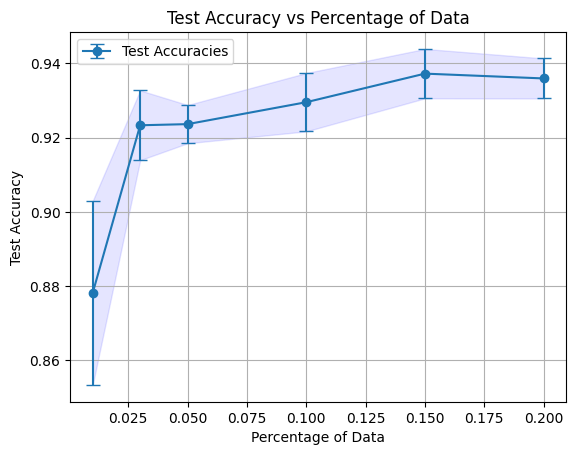

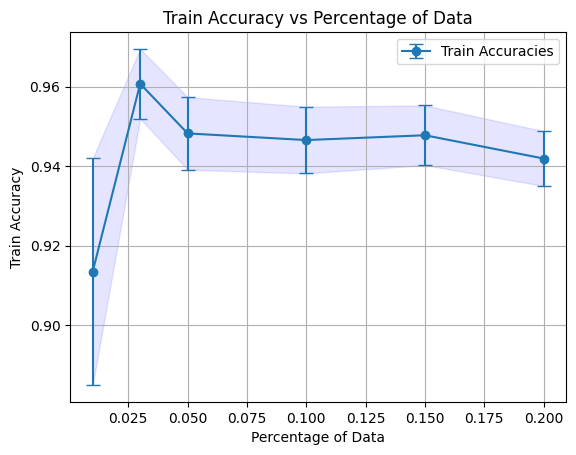

In [53]:
dataloader_wrapped.update_phase('finetune')

percentages_set_1 = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2]
seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
repeats = 3

params['lr'] = 0.01
params['num_train'] = 10
params['early_stop_patience'] = 4

# Store results for each percentage
results_test_finetune_1 = {}
results_train_finetune_1 = {}
best_models_1 = {}
data_loaders_1 = {}
epochs_taken_finetune_1 = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in percentages_set_1:
    print(f"Percentage: {perc}")
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []  # Store epochs for this percentage

    for _, temp_seed in enumerate(seed_set):
        #temp_seed as a random seed
        temp_seed  = random.randint(0, 100)
        print(f"Repeat: {_}, with seed {temp_seed} =========================")

        ''' model_new = generate_fc_dnn(dataset.input_dim, 10, params, gaussian_init=False, activation_function = nn.ReLU)

        # Copy weights
        for name, param in model.named_parameters():
            if "linear" + str(depth) not in name:
                model_new._parameters[name] = param'''

        # Copying model
        model_new = copy.deepcopy(model)

        in_features = model.fc_2.in_features
        out_features = model.fc_2.out_features

        # Reinitializing the second fcnn layer and softmax layer
        model_new.fc_2 = nn.Linear(in_features, out_features)  # Reinitialize with the same shape
        model_new.softmax = nn.Softmax(dim=1)
        
        model_new.to(device)

        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset(dataloader_wrapped.train_loader, perc, balanced = True, seed=temp_seed)
        if _ == 0:
            data_loaders_1[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataloader_wrapped.test_loader
        val_loader_transfer_reduced = dataloader_wrapped.val_loader

        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)

        trainer = Trainer(model_new, dataset_namespace_new, params)
        train_acc_new, test_acc_new, effective_epochs, checkpoints = trainer.train()

        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(effective_epochs)

        print('eval on reduced train set')
        accuracy = eval(model_new, device, train_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])
        print('eval on full test set')
        accuracy = eval(model_new, device, test_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])

        # Uncomment this block if you need the best model per percentage logic
        # if train_acc_new > best_accuracy:
        #     best_accuracy = train_acc_new
        #     best_models[perc] = model_new.state_dict()  # Save only the model's parameters (state_dict)

    results_test_finetune_1[perc] = test_accuracies
    results_train_finetune_1[perc] = train_accuracies
    epochs_taken_finetune_1[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages_set_1:
    for seed, epoch_num in zip(seed_set, epochs_taken_finetune_1[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")


# Save the best models
# for perc in best_models:
#     torch.save(best_models[perc], f"best_model_{int(perc*100)}_percent.pth")

# Plot the results
means = [np.mean(results_test_finetune_1[perc]) for perc in percentages_set_1]
stds = [np.std(results_test_finetune_1[perc]) for perc in percentages_set_1]
plt.errorbar(percentages_set_1, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages_set_1, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train_finetune_1[perc]) for perc in percentages_set_1]
stds = [np.std(results_train_finetune_1[perc]) for perc in percentages_set_1]
plt.errorbar(percentages_set_1, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages_set_1, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


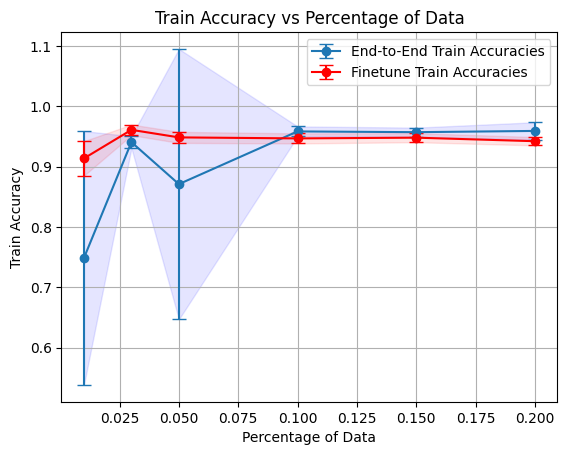

In [54]:
# End to End - Train Accuracies
means = [np.mean(results_train_1[perc]) for perc in percentages_set_1]
stds = [np.std(results_train_1[perc]) for perc in percentages_set_1]
plt.errorbar(percentages_set_1, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Train Accuracies")
plt.fill_between(percentages_set_1, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Train Accuracies
means = [np.mean(results_train_finetune_1[perc]) for perc in percentages_set_1]
stds = [np.std(results_train_finetune_1[perc]) for perc in percentages_set_1]
plt.errorbar(percentages_set_1, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Train Accuracies", color='r')
plt.fill_between(percentages_set_1, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Train Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


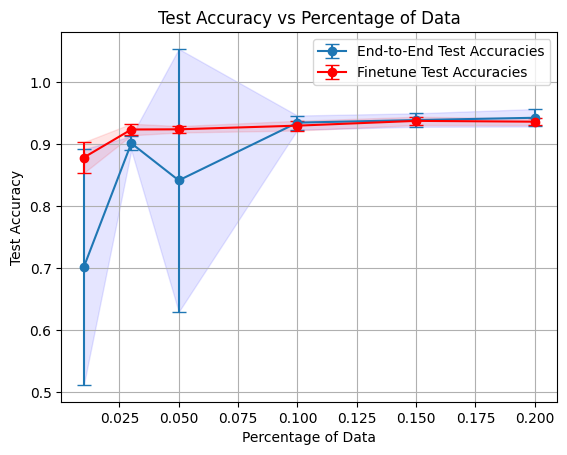

In [55]:
# End to End - Test Accuracies
means = [np.mean(results_test_1[perc]) for perc in percentages_set_1]
stds = [np.std(results_test_1[perc]) for perc in percentages_set_1]
plt.errorbar(percentages_set_1, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Test Accuracies")
plt.fill_between(percentages_set_1, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Test Accuracies
means = [np.mean(results_test_finetune_1[perc]) for perc in percentages_set_1]
stds = [np.std(results_test_finetune_1[perc]) for perc in percentages_set_1]
plt.errorbar(percentages_set_1, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Test Accuracies", color='r')
plt.fill_between(percentages_set_1, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Test Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


Percentage: 0.1
Repeat: 0, with seed 15 =========================
Batch: 0, Loss: 2.144946813583374
Batch: 20, Loss: 0.2840377688407898

Average loss: 0.2025, Accuracy: 2463.0/2645 (93%)


Average loss: 0.2359, Accuracy: 2702.0/2940 (92%)

Epoch: 0 	Training Accuracy: 93.12%
Validation Accuracy: 91.90%
Batch: 0, Loss: 0.14783330261707306
Batch: 20, Loss: 0.10857236385345459

Average loss: 0.2332, Accuracy: 2420.0/2645 (91%)


Average loss: 0.2716, Accuracy: 2661.0/2940 (91%)

Epoch: 1 	Training Accuracy: 91.49%
Validation Accuracy: 90.51%
Batch: 0, Loss: 0.23735424876213074
Batch: 20, Loss: 0.09889884293079376

Average loss: 0.1723, Accuracy: 2486.0/2645 (94%)


Average loss: 0.2271, Accuracy: 2692.0/2940 (92%)

Epoch: 2 	Training Accuracy: 93.99%
Validation Accuracy: 91.56%
Batch: 0, Loss: 0.21462243795394897
Batch: 20, Loss: 0.21370764076709747

Average loss: 0.1144, Accuracy: 2535.0/2645 (96%)


Average loss: 0.1884, Accuracy: 2747.0/2940 (93%)

Epoch: 3 	Training Accuracy: 95.84%
V

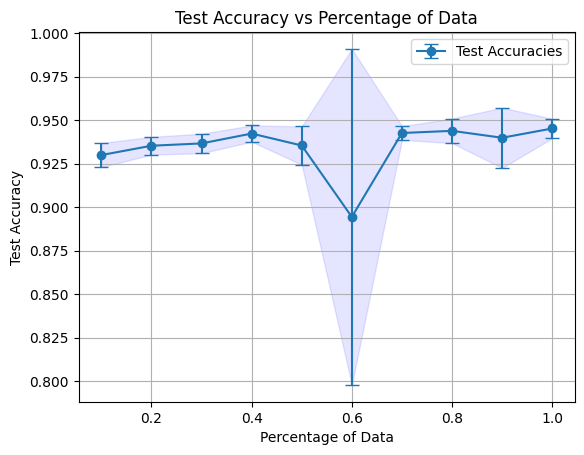

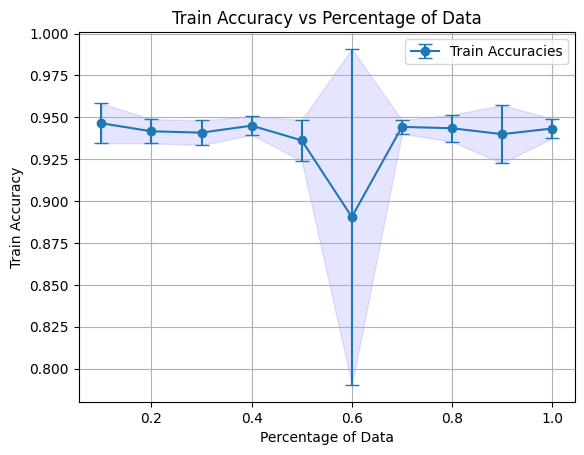

In [56]:
dataloader_wrapped.update_phase('finetune')

percentages_set_2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
repeats = 3

params['lr'] = 0.01
params['num_train'] = 10
params['early_stop_patience'] = 4

# Store results for each percentage
results_test_finetune_2 = {}
results_train_finetune_2 = {}
best_models_2 = {}
data_loaders_2 = {}
epochs_taken_finetune_2 = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in percentages_set_2:
    print(f"Percentage: {perc}")
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []  # Store epochs for this percentage

    for _, temp_seed in enumerate(seed_set):
        #temp_seed as a random seed
        temp_seed  = random.randint(0, 100)
        print(f"Repeat: {_}, with seed {temp_seed} =========================")

        ''' model_new = generate_fc_dnn(dataset.input_dim, 10, params, gaussian_init=False, activation_function = nn.ReLU)

        # Copy weights
        for name, param in model.named_parameters():
            if "linear" + str(depth) not in name:
                model_new._parameters[name] = param'''

        # Copying model
        model_new = copy.deepcopy(model)

        in_features = model.fc_2.in_features
        out_features = model.fc_2.out_features

        # Reinitializing the second fcnn layer and softmax layer
        model_new.fc_2 = nn.Linear(in_features, out_features)  # Reinitialize with the same shape
        model_new.softmax = nn.Softmax(dim=1)
        
        model_new.to(device)
        
        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset(dataloader_wrapped.train_loader, perc, balanced = True, seed=temp_seed)
        if _ == 0:
            data_loaders_2[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataloader_wrapped.test_loader
        val_loader_transfer_reduced = dataloader_wrapped.val_loader

        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)

        trainer = Trainer(model_new, dataset_namespace_new, params)
        train_acc_new, test_acc_new, effective_epochs, checkpoints = trainer.train()

        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(effective_epochs)

        print('eval on reduced train set')
        accuracy = eval(model_new, device, train_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])
        print('eval on full test set')
        accuracy = eval(model_new, device, test_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])

        # Uncomment this block if you need the best model per percentage logic
        # if train_acc_new > best_accuracy:
        #     best_accuracy = train_acc_new
        #     best_models[perc] = model_new.state_dict()  # Save only the model's parameters (state_dict)

    results_test_finetune_2[perc] = test_accuracies
    results_train_finetune_2[perc] = train_accuracies
    epochs_taken_finetune_2[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages_set_2:
    for seed, epoch_num in zip(seed_set, epochs_taken_finetune_2[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")


# Save the best models
# for perc in best_models:
#     torch.save(best_models[perc], f"best_model_{int(perc*100)}_percent.pth")

# Plot the results
means = [np.mean(results_test_finetune_2[perc]) for perc in percentages_set_2]
stds = [np.std(results_test_finetune_2[perc]) for perc in percentages_set_2]
plt.errorbar(percentages_set_2, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages_set_2, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train_finetune_2[perc]) for perc in percentages_set_2]
stds = [np.std(results_train_finetune_2[perc]) for perc in percentages_set_2]
plt.errorbar(percentages_set_2, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages_set_2, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

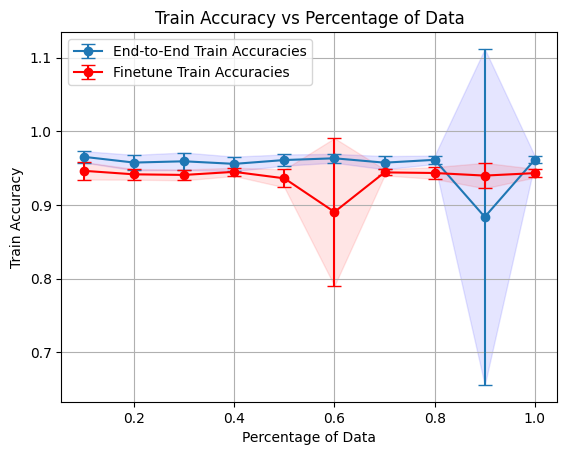

In [57]:
# End to End - Train Accuracies
means = [np.mean(results_train_2[perc]) for perc in percentages_set_2]
stds = [np.std(results_train_2[perc]) for perc in percentages_set_2]
plt.errorbar(percentages_set_2, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Train Accuracies")
plt.fill_between(percentages_set_2, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Train Accuracies
means = [np.mean(results_train_finetune_2[perc]) for perc in percentages_set_2]
stds = [np.std(results_train_finetune_2[perc]) for perc in percentages_set_2]
plt.errorbar(percentages_set_2, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Train Accuracies", color='r')
plt.fill_between(percentages_set_2, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Train Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

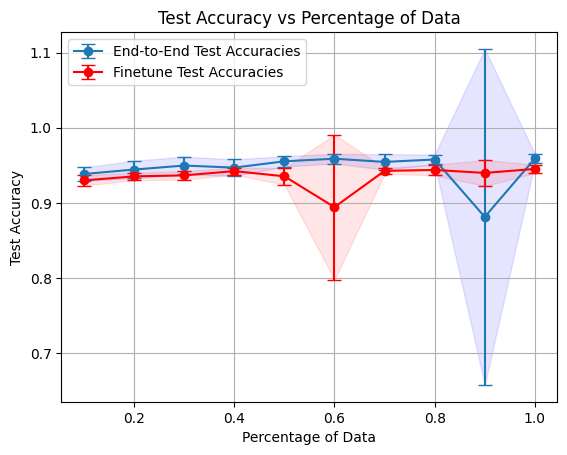

In [58]:
# End to End - Test Accuracies
means = [np.mean(results_test_2[perc]) for perc in percentages_set_2]
stds = [np.std(results_test_2[perc]) for perc in percentages_set_2]
plt.errorbar(percentages_set_2, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Test Accuracies")
plt.fill_between(percentages_set_2, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Test Accuracies
means = [np.mean(results_test_finetune_2[perc]) for perc in percentages_set_2]
stds = [np.std(results_test_finetune_2[perc]) for perc in percentages_set_2]
plt.errorbar(percentages_set_2, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Test Accuracies", color='r')
plt.fill_between(percentages_set_2, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Test Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

In [59]:
import json

data_to_save = {
    "results_test_finetune_1": results_test_finetune_1,
    "results_train_finetune_1": results_train_finetune_1,
    "epochs_taken_finetune_1": epochs_taken_finetune_1,
    
    "results_test_finetune_2": results_test_finetune_2,
    "results_train_finetune_2": results_train_finetune_2,
    "epochs_taken_finetune_2": epochs_taken_finetune_2,
    
    "results_test_2": results_test_2,
    "results_train_2": results_train_2,
    "epochs_taken_2": epochs_taken_2,
    
    "results_test_1": results_test_1,
    "results_train_1": results_train_1,
    "epochs_taken_1": epochs_taken_1
}

# Assuming data_to_save from the previous code
with open("data.json", "w") as file:
    json.dump(data_to_save, file)

In [60]:
print(model_new)

CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=121, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
  (softmax): Softmax(dim=1)
)


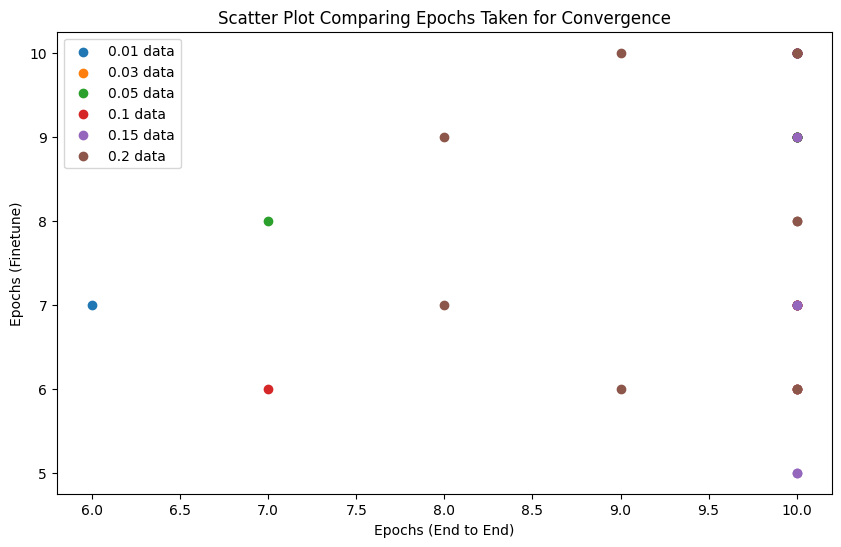

In [61]:
plt.figure(figsize=(10, 6))
for perc in percentages_set_1:
    plt.scatter(epochs_taken_1[perc], epochs_taken_finetune_1[perc], label=f'{perc} data')
plt.xlabel('Epochs (End to End)')
plt.ylabel('Epochs (Finetune)')
plt.title('Scatter Plot Comparing Epochs Taken for Convergence')
plt.legend()
plt.show()


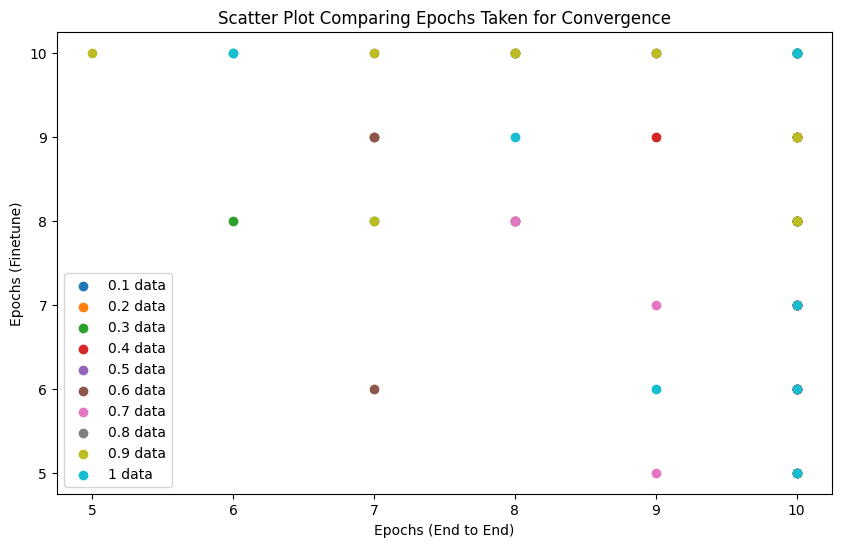

In [62]:
plt.figure(figsize=(10, 6))
for perc in percentages_set_2:
    plt.scatter(epochs_taken_2[perc], epochs_taken_finetune_2[perc], label=f'{perc} data')
plt.xlabel('Epochs (End to End)')
plt.ylabel('Epochs (Finetune)')
plt.title('Scatter Plot Comparing Epochs Taken for Convergence')
plt.legend()
plt.show()

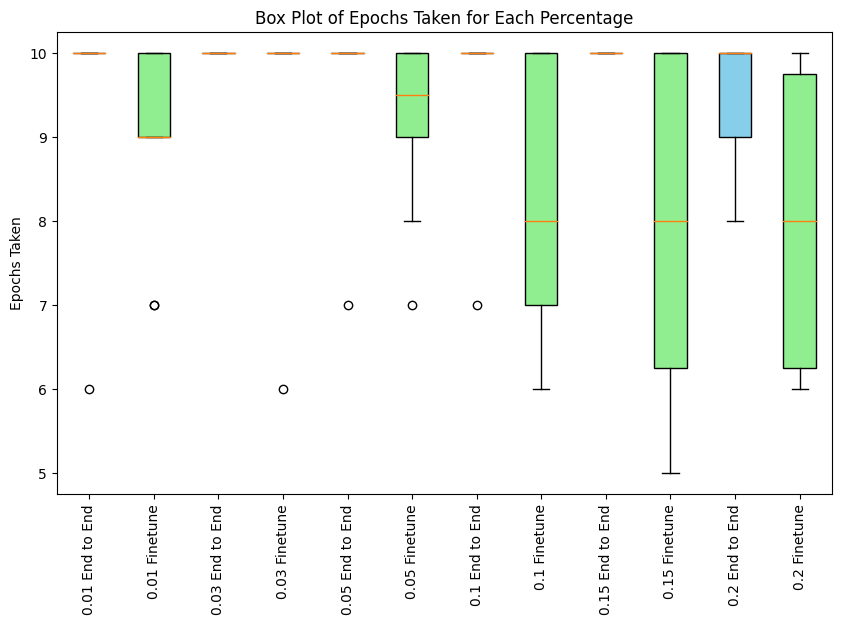

In [63]:
# Given data
percentages_set_1 = list(epochs_taken_1.keys())

all_epochs = []
labels = []

for perc in percentages_set_1:
    all_epochs.extend([epochs_taken_1[perc], epochs_taken_finetune_1[perc]])
    labels.extend([f'{perc} End to End', f'{perc} Finetune'])

# Plotting
plt.figure(figsize=(10, 6))
box = plt.boxplot(all_epochs, labels=labels, patch_artist=True)

# Coloring
colors = ['skyblue', 'lightgreen'] * len(percentages_set_1)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Epochs Taken')
plt.title('Box Plot of Epochs Taken for Each Percentage')
plt.xticks(rotation=90)
plt.show()


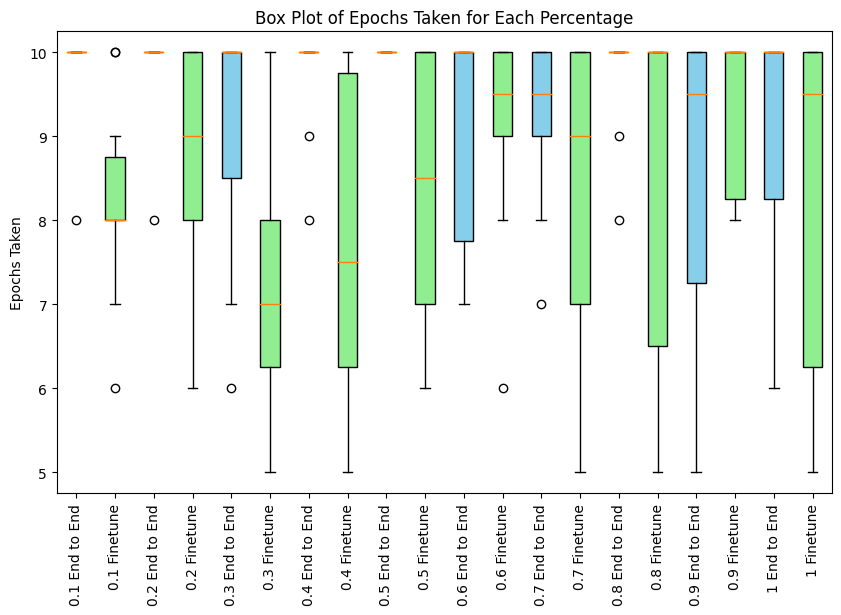

In [64]:
# Given data
percentages_set_2 = list(epochs_taken_2.keys())

all_epochs = []
labels = []

for perc in percentages_set_2:
    all_epochs.extend([epochs_taken_2[perc], epochs_taken_finetune_2[perc]])
    labels.extend([f'{perc} End to End', f'{perc} Finetune'])

# Plotting
plt.figure(figsize=(10, 6))
box = plt.boxplot(all_epochs, labels=labels, patch_artist=True)

# Coloring
colors = ['skyblue', 'lightgreen'] * len(percentages_set_2)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Epochs Taken')
plt.title('Box Plot of Epochs Taken for Each Percentage')
plt.xticks(rotation=90)
plt.show()